# Converts_global_fire_emission_database_tonetcdf

For this work we used the files that can be found here: **https://www.globalfiredata.org/data.html**

The hdf5 files include fire carbon emissions (g C m-2 month-1) and dry matter emissions (kg DM m-2 month-1). 

Recommended emission factors (g species per kg dry matter burned) to calculate specific trace gas and aerosol emissions in combination with above listed fractional contributions: **https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/**

The Python code from **https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/** was adapted.

https://globalfiredata.org/pages/data/

https://www.geo.vu.nl/~gwerf/GFED/GFED4/Readme.pdf

https://www.geo.vu.nl/~gwerf/GFED/GFED4/

https://modis-fire.umd.edu/files/MODIS_C6_Fire_User_Guide_C.pdf

https://firms.modaps.eosdis.nasa.gov/

The spatial	resolution of the global files is 0.25 degrees, so the different fields have 720 rows and 1440 columns.	The	center of the upper	left grid cell is located at longitude -179.875° and latitude 89.875°. The temporal resolution of the emissions files is monthly, and we provide data to distribute these over the month as	well as	a diurnal cycle	based on Mu	et	al.	(2011). This is	only available om 2003 onwards.

From 2003 there a 3-hourly resolution, essentially you take the gCm-2month-1 which is the amount emitted per a month - you can then reduce it by multiplying by a fraction of the day and hour. 

To get an hourly resolution we can using the 3 hourly value and just divide by 3

In [4]:
from datetime import datetime, timedelta
import numpy as np
import h5py # if this creates an error please make sure you have the h5py library
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cmocean
import glob
import os
from pathlib import Path

xr.backends.file_manager.FILE_CACHE.clear()

In [5]:
directory = r'E:\Global_Fire_Emissions_Database\data_hdf5'
savepath = r'E:\Global_Fire_Emissions_Database\netcdfs'

EFs_df = pd.read_csv(directory+'/GFED4_Emission_Factors.txt', skiprows=16, sep='\s+')
EFs_df = EFs_df.reset_index()

EFs_df.columns = ['SPECIE', 'SAVA', 'BORF', 'TEMF', 'DEFO', 'PEAT', 'AGRI']
hours = ['UTC_0-3h', 'UTC_12-15h', 'UTC_15-18h', 'UTC_18-21h', 'UTC_21-24h', 'UTC_3-6h', 'UTC_6-9h', 'UTC_9-12h']
hours_for_datetime = [1.5, 13.5, 16.5, 19.5, 22.5, 4.5, 7.5, 10.5]

In [6]:
EFs_df.head(2)

,SPECIE,SAVA,BORF,TEMF,DEFO,PEAT,AGRI
0,DM,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
1,C,488.273,464.989,489.416,491.751,570.055,480.352


In [7]:
def produce_xarray(emissions_list, datetimes, emission_type, datetime_var="datetime"): 
    print("produce xarray using emission list, datetimes and emission type for "+str(emission_type))
    
    if isinstance(datetimes[0], datetime) == False:
        print("not datetimes")
        dates = [datetime.strptime(x, '%Y%m') for x in datetimes]
    if isinstance(datetimes[0], datetime) == True:
        dates = datetimes
    emissions_list_dstack = np.dstack(emissions_list)
    lats = np.arange(90, -90, -0.25)
    lons = np.arange(-180,180, 0.25)
    
    print(emissions_list_dstack)
    print(dates)
    print("lengths")
    print(len(emissions_list_dstack))
    print(len(dates))
    
    ds = xr.Dataset(data_vars={emission_type:(["lat","lon",datetime_var], emissions_list_dstack),}, 
                    coords={"lat": lats, "lon": lons, datetime_var: dates})
    ds[emission_type].attrs["units"] = "g "+str(emission_type)+"m$^{-2}$"
    return ds

# Monthly (this is without applying the 3-hourly resolution): 

In [7]:
emission_type='BC'
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
sources = ['SAVA','BORF','TEMF','DEFO','PEAT','AGRI']
start_year = 2002
end_year   = 2023

## Append the GFED data on a monthly resolution: 

In [8]:
def append_files_into_xarray_just_monthly(start_year, end_year, months, emission_type='BC',                              
                             sources=['SAVA','BORF','TEMF','DEFO','PEAT','AGRI'],                               
                             directory=r'E:\Global_Fire_Emissions_Database\data_hdf5', 
                             savepath='E:\\Global_Fire_Emissions_Database\\netcdfs\\monthly'):
    species = [] # names of the different gas and aerosol species
    EFs     = np.zeros((41, 6)) # 41 species, 6 sources

    k = 0
    f = open(directory+'/GFED4_Emission_Factors.txt')
    while 1:
        line = f.readline()
        if line == "":
            break
        if line[0] != '#':
            contents = line.split()
            species.append(contents[0])
            EFs[k,:] = contents[1:]
            k += 1
    f.close()
    # we are interested in CO for this example (4th row):
    index_emission_type = EFs_df[EFs_df['SPECIE'] == emission_type].index.values[0]
    EF_type = EFs[index_emission_type,:]

    type_emissions_list = []
    datetimes = []
    for year in range(start_year, end_year):
        print(year)
        string = directory+'/GFED4.1s_'+str(year)+'.hdf5'

        if year in [2017, 2018, 2019, 2020, 2021, 2022, 2023]:
            string = directory+'/GFED4.1s_'+str(year)+'_beta.hdf5'

        try:
            f = h5py.File(string, 'r')         
            for month in range(12):
                # read in DM emissions
                string = '/emissions/'+months[month]+'/DM'
                DM_emissions = f[string][:]
                print(DM_emissions.mean())

                type_emissions = np.zeros((720, 1440))
                for source in range(6):
                    print("source: "+str(sources[source])) # read in the fractional contribution of each source
                    string = '/emissions/'+months[month]+'/partitioning/DM_'+sources[source]
                    contribution = f[string][:]
                    print(contribution.shape) #(720, 1440) lat is 720 and lon is 1440
                    # calculate CO emissions as the product of DM emissions (kg DM per 
                    # m2 per month), the fraction the specific source contributes to 
                    # this (unitless), and the emission factor (g CO per kg DM burned)
                    type_emissions += DM_emissions * contribution * EF_type[source]    
                    print("mean: "+str(type_emissions.mean()))
                print("mean after sum :"+str(type_emissions.mean()))    
                type_emissions_list.append(type_emissions)            
                print("BC: "+str(len(type_emissions_list)))            
                print("month: "+str(months[month]))
                print(month+1)            
                month2d = "{:02d}".format(month+1) #make 0X
                datetime_value = str(year)+str(month2d)
                datetimes.append(datetime_value)
                print("datetime: "+str(len(datetimes)))   
        except:
            pass
    ds = produce_xarray(type_emissions_list, datetimes, emission_type, datetime_var="datetime")
    ds = ds.sortby("datetime")
    path_file = savepath+"//"+str(emission_type)+'_monthly_'+str(start_year)+".nc"
    print(path_file)
    
    if not os.path.exists(savepath):
        os.makedirs(savepath)
        
    path = Path(path_file)
    if path.exists():
        path.unlink()
    ds.to_netcdf(path)
    return ds

In [9]:
savepath_monthly = savepath+'//monthly'

for year in np.arange(2002, 2003):
    ds_month = append_files_into_xarray_just_monthly(start_year=year, end_year=year+1, 
                                          months=['01','02','03','04','05','06','07','08','09','10','11','12'], 
                                          emission_type='BC',                              
                                 sources=['SAVA','BORF','TEMF','DEFO','PEAT','AGRI'],                               
                                directory=r'E:\Global_Fire_Emissions_Database\data_hdf5', 
                                savepath='E:\\Global_Fire_Emissions_Database\\netcdfs\\monthly')

2002
0.00045718858
source: SAVA
(720, 1440)
mean: 0.0001412948874005722
source: BORF
(720, 1440)
mean: 0.00014137345564360648
source: TEMF
(720, 1440)
mean: 0.00015273115780694085
source: DEFO
(720, 1440)
mean: 0.0001674341844973998
source: PEAT
(720, 1440)
mean: 0.000167455260907407
source: AGRI
(720, 1440)
mean: 0.0001851822601014233
mean after sum :0.0001851822601014233
BC: 1
month: 01
1
datetime: 1
0.00034971445
source: SAVA
(720, 1440)
mean: 9.486239937011241e-05
source: BORF
(720, 1440)
mean: 9.492487262214701e-05
source: TEMF
(720, 1440)
mean: 9.87589989792582e-05
source: DEFO
(720, 1440)
mean: 0.00012573865649216762
source: PEAT
(720, 1440)
mean: 0.00012615839557595138
source: AGRI
(720, 1440)
mean: 0.00014352761597711424
mean after sum :0.00014352761597711424
BC: 2
month: 02
2
datetime: 2
0.00016386411
source: SAVA
(720, 1440)
mean: 3.9854976851921444e-05
source: BORF
(720, 1440)
mean: 4.0797125489920886e-05
source: TEMF
(720, 1440)
mean: 4.442099695505439e-05
source: DEFO
(72

# Get fractions: 

In [9]:
def get_days_fraction(year, month, day):
    string = directory+'/GFED4.1s_'+str(year)+'.hdf5'
    if year in [2017, 2018, 2019, 2020, 2021, 2022, 2023]:
        string = directory+'/GFED4.1s_'+str(year)+'_beta.hdf5'
    f = h5py.File(string, 'r')
    string = '/emissions/'+month+'/daily_fraction/'+day
    days_fraction = f[string][:]
    return days_fraction

def get_hours_fraction(year, month, hour):
    string = directory+'/GFED4.1s_'+str(year)+'.hdf5'
    if year in [2017, 2018, 2019, 2020, 2021, 2022, 2023]:
        string = directory+'/GFED4.1s_'+str(year)+'_beta.hdf5'
        print(string)
    f = h5py.File(string, 'r')
    string = '/emissions/'+month+'/diurnal_cycle/'+hour
    hours_fraction = f[string][:]
    return hours_fraction

def plot(days_fraction):
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(111)
    ax.set_title('days fraction')
    plt.imshow(days_fraction)
    ax.set_aspect('equal')
    plt.colorbar(orientation='vertical')
    plt.show()
    
def create_day_fraction(years):
    dict_date_fraction = {}
    months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    for year in years:
        for month in months:
            for day in np.arange(1, 32, 1):
                day_string='day_'+str(day)
                try:                
                    day_to_add = str(day)
                    day2d = "{:02d}".format(int(day_to_add))                  

                    datetime_value = str(year)+str(month)+str(day2d)
                    datetime_value = datetime.strptime(datetime_value, '%Y%m%d')
                    print(datetime_value)
                    days_fraction = get_days_fraction(year, month, day_string)
                    print("days fraction mean: "+str(days_fraction.mean()))  
                    dict_date_fraction[datetime_value] = days_fraction.mean()
                except:
                    pass

    df_day_fraction = pd.DataFrame(dict_date_fraction.items(), columns=['Date', 'values'])
    df_day_fraction = df_day_fraction.set_index('Date')
    df_day_fraction.index = pd.to_datetime(df_day_fraction.index)   
    return df_day_fraction

def fancy(ax, fontsize=20):    
    # thickning the axes spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=0.5)    
    # mask top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

days fraction mean: 0.0010316519
days fraction mean: 0.00093753013


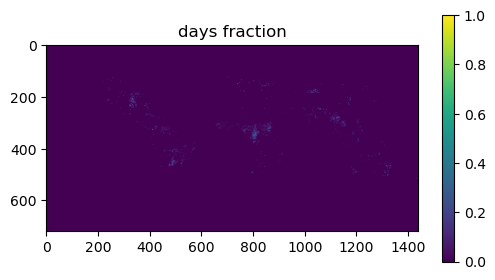

In [10]:
days_fraction = get_days_fraction(year=2003, month='04', day='day_1')
print("days fraction mean: "+str(days_fraction.mean()))

days_fraction = get_days_fraction(year=2004, month='04', day='day_1')
print("days fraction mean: "+str(days_fraction.mean()))

plot(days_fraction)

In [ ]:
df_day_fraction = create_day_fraction(np.arange(2003, 2024, 1))

In [12]:
df_day_fraction.head(2)

,values
Date,
2003-01-01,0.000573
2003-01-02,0.000609


In [13]:
def create_hour_fraction(years=np.arange(2003, 2024, 1)):
    dict_hour_fraction = {}
    months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    hours = ['UTC_0-3h','UTC_3-6h', 'UTC_6-9h', 'UTC_9-12h', 'UTC_12-15h', 'UTC_15-18h', 'UTC_18-21h', 'UTC_21-24h']
    hours_for_datetime = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5]
    dict_hours = dict(zip(hours, hours_for_datetime))
    for year in years:
        for month in months:
            for hour in hours:               
                try:                   
                    hours_to_add = dict_hours[hour]
                    datetime_value = str(year)+str(month)
                    datetime_value = datetime.strptime(datetime_value, '%Y%m')
                    datetime_value = datetime_value + timedelta(hours=hours_to_add)  
                    datetime_value = pd.to_datetime(datetime_value, format='%Y-%m-%d %H:%M:%S')
                    hours_fraction = get_hours_fraction(year, month, hour)                    
                    dict_hour_fraction[datetime_value] = hours_fraction.mean()
                except:
                    pass

    df_hour_fraction = pd.DataFrame(dict_hour_fraction.items(), columns=['Date', 'values'])
    df_hour_fraction = df_hour_fraction.set_index('Date')
    df_hour_fraction.index = pd.to_datetime(df_hour_fraction.index) 
    df_hour_fraction = df_hour_fraction.sort_index()
    return df_hour_fraction

In [ ]:
df_hour_fraction = create_hour_fraction(np.arange(2003, 2024, 1))

In [15]:
df_hour_fraction.head(2)

,values
Date,
2003-01-01 01:30:00,0.121676
2003-01-01 04:30:00,0.122959


In [16]:
df_hour_fraction['months'] = df_hour_fraction.index.month
df_hour_fraction['year'] = df_hour_fraction.index.year - df_hour_fraction.index.year[0] + 1
df_hour_fraction['date'] = df_hour_fraction.index.date

C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


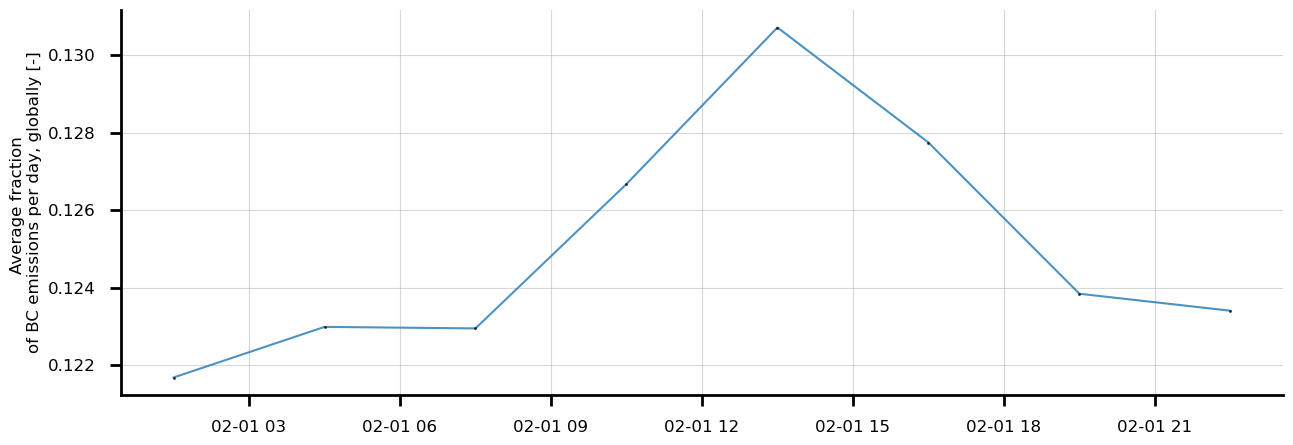

In [17]:
#example day:

df_hour_fraction_ = df_hour_fraction[df_hour_fraction['date'] == pd.to_datetime('2004-02-01')]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_hour_fraction_.index, df_hour_fraction_['values'], 'o-', mfc='None', mec='k', alpha=.8, ms=1)
fancy(ax, fontsize=12)
ax.set_ylabel('Average fraction \nof BC emissions per day, globally [-]', fontsize=12)
#plt.ylim(0, 0.14)
plt.show()

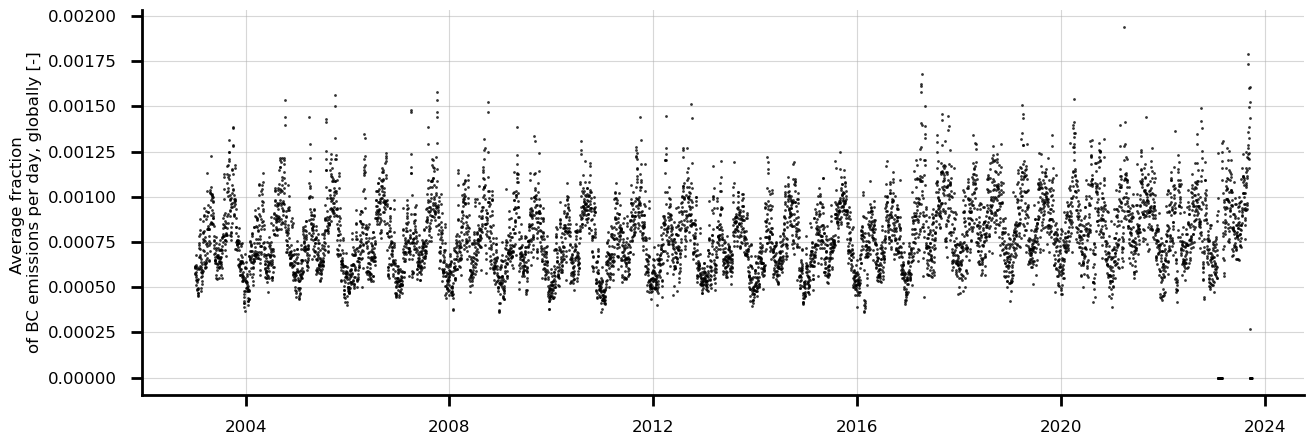

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_day_fraction.index, df_day_fraction.values, 'o', mfc='None', mec='k', alpha=.8, ms=1)
fancy(ax, fontsize=12)
ax.set_ylabel('Average fraction \nof BC emissions per day, globally [-]', fontsize=12)
plt.show()

In [19]:
df_hour_fraction.head(2)

,values,months,year,date
Date,,,,
2003-01-01 01:30:00,0.121676,1,1,2003-01-01
2003-01-01 04:30:00,0.122959,1,1,2003-01-01


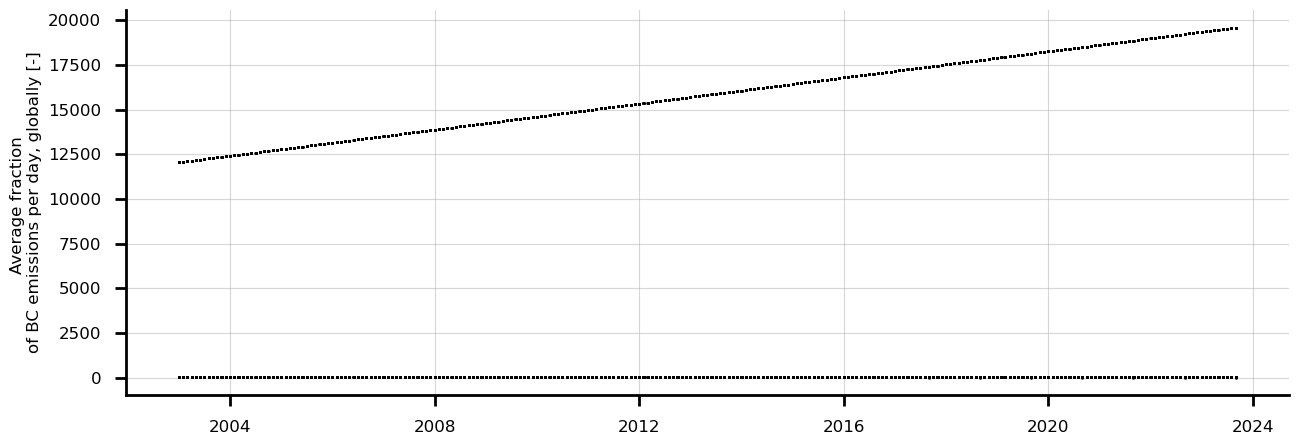

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_hour_fraction.index, df_hour_fraction.values, 'o', mfc='None', mec='k', alpha=.8, ms=1)
fancy(ax, fontsize=12)
ax.set_ylabel('Average fraction \nof BC emissions per day, globally [-]', fontsize=12)
plt.show()

# load hours: 

In [21]:
def append_files_into_xarray(start_year, end_year, emission_type='BC', 
                             months=['01','02','03','04','05','06','07','08','09','10','11','12'], 
                             sources=['SAVA','BORF','TEMF','DEFO','PEAT','AGRI'], 
                             hours=['UTC_0-3h', 'UTC_3-6h', 'UTC_6-9h', 'UTC_9-12h', 'UTC_12-15h', 'UTC_15-18h', 'UTC_18-21h', 'UTC_21-24h'],
                             hours_for_datetime=[1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5], 
                             directory=directory, savepath='E:\\Global_Fire_Emissions_Database\\netcdfs\\'):
    
    dict_hours = dict(zip(hours, hours_for_datetime))
    print(dict_hours)
    species = [] # names of the different gas and aerosol species
    EFs = np.zeros((41, 6)) # 41 species, 6 sources

    k = 0
    f = open(directory+'/GFED4_Emission_Factors.txt')
    while 1:
        line = f.readline()
        if line == "":
            break

        if line[0] != '#':
            contents = line.split()
            species.append(contents[0])
            EFs[k,:] = contents[1:]
            k += 1                
    f.close()

    # we are interested in CO for this example (4th row):
    index_emission_type = EFs_df[EFs_df['SPECIE'] == emission_type].index.values[0]
    EF_type = EFs[index_emission_type,:]

    for year in range(start_year, end_year):
        print("year: "+str(year)) #load for each year
        string = directory+'/GFED4.1s_'+str(year)+'.hdf5'    
        if year in [2017, 2018, 2019, 2020, 2021, 2022, 2023]:
            string = directory+'/GFED4.1s_'+str(year)+'_beta.hdf5'    
                
        try:
            f = h5py.File(string, 'r')  
            for month_num, month in enumerate(months):
                print("NEW MONTH\n")
                print("reduce lists to empty")
                type_emissions_list = [] #set equal to zero at the start of each month
                datetimes = []                
                print("month: "+str(month))                                                
                print(type_emissions_list)                
                string = '/emissions/'+months[month_num]+'/DM'
                print(string)
                DM_emissions = f[string][:]
                
                string = '/emissions/'+months[month_num]+'/daily_fraction'
                days = list(f[string].keys())
                print(days)
                print("number of days "+str(len(days)))     

                for day_num, day in enumerate(days):
                    string = '/emissions/'+months[month_num]+'/daily_fraction/'+days[day_num]
                    print(string)
                    days_fraction = f[string][:]
                                        
                    print("days_fraction:")                    
                    print("mean:")
                    print(np.mean(days_fraction))

                    DM_emissions_days = DM_emissions * days_fraction
                    
                    string = '/emissions/'+months[month_num]+'/diurnal_cycle/'
                    hours_fraction = list(f[string].keys())
                    print("number of hour fractions "+str(len(hours_fraction)))

                    for hour in range(len(hours_fraction)):
                        string = '/emissions/'+months[month_num]+'/diurnal_cycle/'+hours[hour]
                        print(string)
                        
                        hours_fraction = f[string][:]
                        print("Hours fracton:")                        
                        print("mean:")
                        print(np.mean(hours_fraction))
                        
                        DM_emissions_hours = DM_emissions_days * hours_fraction  

                        month2d = "{:02d}".format(int(months[month_num])) #make 0X
                        print("month old: "+str(month2d))
                        month2d = months[month_num] #make 0X
                        print("month new: "+str(month2d))
                        
                        print(str(days[day_num]))
                        day_to_add = str(days[day_num])[4:] #'day_XX' this format
                        print(day_to_add)    
                        
                        
                        day2d = "{:02d}".format(int(day_to_add))
                        
                        hours_to_add = dict_hours[hours[hour]]
                        print(hours_to_add)
                                                
                        datetime_value = str(year)+str(month2d)+str(day2d)
                        datetime_value = datetime.strptime(datetime_value, '%Y%m%d')
                        datetime_value = datetime_value + timedelta(hours=hours_to_add)  
                        datetime_value = pd.to_datetime(datetime_value, format='%Y-%m-%d %H:%M:%S')
                        print(datetime_value)
                        
                        print("empty hours")
                        type_emissions_hours = np.zeros((720, 1440)) #start new for each month
                        for source in range(6):
                            print("source: "+str(sources[source]))              
                            string = '/emissions/'+months[month_num]+'/partitioning/DM_'+sources[source]
                            contribution = f[string][:]     
                            type_emissions_hours += DM_emissions_hours * contribution * EF_type[source]               
                                           
                        print("after appeneded calculation append to the list: ")
                        type_emissions_list.append(type_emissions_hours)
                        datetimes.append(datetime_value)   
                        print("mean of list to append:")
                        print(np.mean(type_emissions_hours))
                        print("appending list mean:")                        
                        print(np.mean(type_emissions_list))                                                
                        print(str(emission_type)+": length of emission list "+str(len(type_emissions_list)))            
                
                #for a whole month of data save (lat: 720, lon: 1440, datetime: 248)
                ds = produce_xarray(type_emissions_list, datetimes, emission_type, datetime_var="datetime")
                print(ds)
                ds = ds.sortby("datetime")
                print("ds mean")
                print(ds.mean()) 
                
                if not os.path.exists(savepath):
                    os.makedirs(savepath)
                ds.to_netcdf(savepath+"//"+str(emission_type)+'_'+str(start_year)+"_"+str(month2d)+".nc")
                print("saved: "+str(savepath))
        except:
            pass

In [ ]:
for year in np.arange(2004, 2024):
    months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if year == 2023:
        months = ['01','02','03','04','05','06','07','08','09']
    if year == 2004:
        months = ['06','07','08','09', '10','11','12']
    append_files_into_xarray(start_year=year, end_year=year+1, months=months,
                            directory=directory, savepath=savepath)

# Load: 

In [9]:
loadpath = 'E:\\Global_Fire_Emissions_Database\\netcdfs'
print(loadpath)
files = glob.glob(loadpath+'\\*')
print(files[-1])

year = 2003
month = 1
month2d = "{:02d}".format(month)

print(files[-1])
print(loadpath+'\\BC_'+str(year)+'_'+str(month2d)+'.nc')

file = loadpath+'\\BC_'+str(year)+'_'+str(month2d)+'.nc'
#ds_year = xr.open_dataset(loadpath+'\\BC_'+str(year)+'_'+str(month2d)+'.nc')

ds_year = xr.open_dataset(file)

E:\Global_Fire_Emissions_Database\netcdfs
E:\Global_Fire_Emissions_Database\netcdfs\BC_2003_01.nc
E:\Global_Fire_Emissions_Database\netcdfs\BC_2003_01.nc
E:\Global_Fire_Emissions_Database\netcdfs\BC_2003_01.nc


In [10]:
def open_xr(loadpath, year = 2011, month = 8):
    month2d = "{:02d}".format(month)
    print(loadpath+'\\BC_'+str(year)+'_'+str(month2d)+'.nc')
    file = loadpath+'\\BC_'+str(year)+'_'+str(month2d)+'.nc'
    ds_year = xr.open_dataset(file)
    return ds_year

In [39]:
month = 1
month2d = "{:02d}".format(month)
ds_year = open_xr(loadpath, year = 2003, month = month)
ds_sel = ds_year.sel(datetime = str(year)+'-'+str(month2d)+'-01', method='nearest')
print(ds_sel.mean())

ds_year = open_xr(loadpath, year = 2003, month = month)
ds_sel = ds_year.sel(datetime = str(year)+'-'+str(month2d)+'-19', method='nearest')
print(ds_sel.mean())

E:\Global_Fire_Emissions_Database\netcdfs\BC_2003_01.nc
<xarray.Dataset>
Dimensions:   ()
Coordinates:
    datetime  datetime64[ns] 2003-01-01T01:30:00
Data variables:
    BC        float64 8.316e-08
E:\Global_Fire_Emissions_Database\netcdfs\BC_2003_01.nc
<xarray.Dataset>
Dimensions:   ()
Coordinates:
    datetime  datetime64[ns] 2003-01-19T01:30:00
Data variables:
    BC        float64 7.529e-07


In [ ]:
da1 = open_xr(loadpath, year = 2011, month = 8)
da2 = open_xr(loadpath, year = 2011, month = 9)

da1_2 = xr.concat([da1, da2], dim="datetime")

# Plot data: 

In [11]:
def XR_plot(XR_Dataset, emission_type):
    fig = plt.figure(1, figsize=[7,5])
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=0))    
    ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())    
    XR_Dataset[emission_type].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat',
                                                    vmin=0, vmax=float(XR_Dataset[emission_type].mean()))
    ax.coastlines()
    plt.show()
    return fig

def create_projections_dict(ZEP_lat, ZEP_lon, central_longitude):
    dict_projections = {}
    
    geo = ccrs.Geodetic(); dict_projections['geo'] = geo
    rotated_pole = ccrs.RotatedPole(pole_latitude=ZEP_lat, pole_longitude=ZEP_lon, central_rotated_longitude=central_longitude)
    dict_projections['rotated_pole'] = rotated_pole
    North_Stereo = ccrs.NorthPolarStereo() 
    dict_projections['North_Stereo'] = North_Stereo
    ortho = ccrs.Orthographic(central_longitude=ZEP_lon, central_latitude=ZEP_lat)
    dict_projections['ortho'] = ortho
    Nearside = ccrs.NearsidePerspective(central_longitude=ZEP_lon, central_latitude=ZEP_lat, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)
    dict_projections['Nearside'] = Nearside
    PlateCarree = ccrs.PlateCarree()
    dict_projections['PlateCarree'] = PlateCarree
    rotated_pole = ccrs.RotatedPole(pole_latitude=ZEP_lat, pole_longitude=ZEP_lon)  
    dict_projections['rotated_pole'] = rotated_pole
    
    return dict_projections     
          
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines(resolution='50m')
    #ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.2, linestyle='--')
    
def polarCentral_set_latlim(lat_lims, ax):
    # Compute a circle in axes coordinates, which we can use as a boundary
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
def circular_traj_plots(XR_Dataset, emission_type, axes_projection='North_Stereo', 
                        title='', ZEP_lat=78.906, ZEP_lon=11.888, central_longitude=0,
                        orientation='horizontal', colourbar_label='', colourbar_labelsize=20, 
                        colourbar_tick_fontsize=12, scientific_notation=True, 
                        decimal_places_colourbar=0, extend=None, cb_pos_x=.95, cb_width=0.02):  
    
    dict_projections = create_projections_dict(ZEP_lat, ZEP_lon, central_longitude)                   
    projection = dict_projections[axes_projection]
    
    fig, ax = sp_map(1, projection=projection, figsize=(6,6))

    lat_lims = [50,90]
    polarCentral_set_latlim(lat_lims, ax)
    add_map_features(ax)
   
    ax.coastlines(resolution="50m", linewidth=1)
    ax.gridlines(alpha=.2, lw=1)  
    
    array = XR_Dataset[emission_type]

    gridlons, gridlats = np.meshgrid(np.array(XR_Dataset['lon']),np.array(XR_Dataset['lat']))
    mapped_grid = ax.pcolormesh(gridlons, gridlats, array, transform=ccrs.PlateCarree(),
                                            vmin=0, vmax=float(array.mean()), cmap = cmocean.cm.thermal)    
    cb = plt.colorbar(mapped_grid, orientation="vertical", pad=0.02, extend='both',
                      aspect=16, shrink=0.8)
    cb.set_label(str(emission_type)+" [gm$^{-2}$]", rotation=270,labelpad=25, size=16)
    geo = dict_projections['geo']    
    ax.plot([ZEP_lon], [ZEP_lat], 'bo', ms=5, alpha=0.5, transform=geo) 
    ax.set_title(str(title), loc='left', size=15)       
    plt.show()
    return fig

In [12]:
def no_zeros(ds):
    ds = ds.where(ds[emission_type] != 0.0)
    return ds

def change_lon(ds):     
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    return ds

def resample_ds_month_mean(ds, freq='M'):
    ds_mean = ds.resample(datetime=freq).mean()
    return ds_mean

def resample_mean_hour(ds, freq='H'):
    ds_mean = ds.resample(datetime=freq).mean()
    return ds_mean

def take_ds_mean_datetime(ds):
    ds_mean = ds.mean(dim='datetime')
    return ds_mean

# Look at exaple year by removing the zeroso, changing the coordinates and taking the mean,

In [ ]:
ds_sel = ds_year.sel(datetime = '2004-03-01', method='nearest')
print(ds_sel.mean())
ds_sel = ds_year.sel(datetime = '2004-03-15', method='nearest')
print(ds_sel.mean())

In [13]:
ds_year = no_zeros(ds_year)
ds_year = change_lon(ds_year)
ds_year_mean = take_ds_mean_datetime(ds_year)

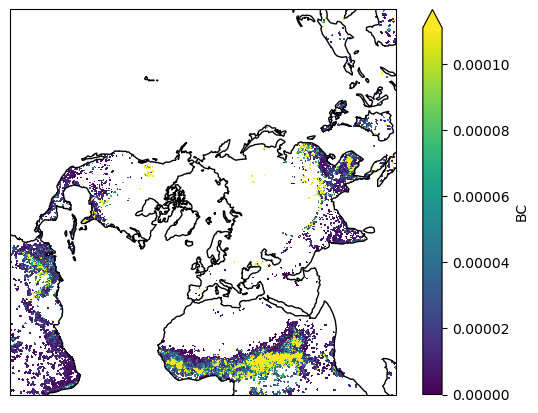

In [14]:
fig = XR_plot(ds_year_mean, emission_type='BC')

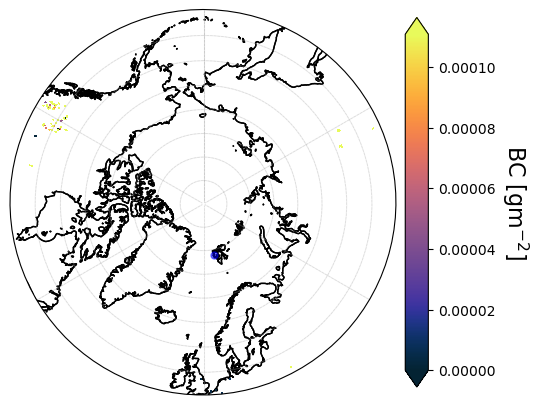

In [15]:
fig = circular_traj_plots(ds_year_mean, emission_type, axes_projection='North_Stereo', 
                        title='', ZEP_lat=78.906, ZEP_lon=11.888, central_longitude=0)

# Select for certain datetimes: 

In [16]:
ds_year

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, datetime: 248)
Coordinates:
  * lat       (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon       (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * datetime  (datetime) datetime64[ns] 2003-01-01T01:30:00 ... 2003-01-31T22...
Data variables:
    BC        (lat, lon, datetime) float64 nan nan nan nan ... nan nan nan nan

In [ ]:
datetime_value = '2023-03-01'

ds_sel = ds_year.sel(datetime = datetime_value, method='nearest')
title = str(pd.to_datetime(ds_sel.datetime.values).date())[:7]
print(title)
fig = circular_traj_plots(ds_sel, emission_type, axes_projection='North_Stereo', 
                        title=title, ZEP_lat=78.906, ZEP_lon=11.888, central_longitude=0)

In [ ]:
ds_sel

## select month and year: 

In [ ]:
def select_month_year(ds, year, month):
    ds_month_year = ds.where(((ds['datetime.year'] == year) & (ds['datetime.month'] == month)), drop=True)
    return ds_month_year

In [ ]:
year=2004; month=3

ds_01_2022 = select_month_year(ds_year, year=year, month=month)

ds_01_2022_mean = take_ds_mean_datetime(ds_01_2022)
title =  str(year)+' '+str(month)
fig = circular_traj_plots(ds_01_2022_mean, emission_type, axes_projection='North_Stereo', 
                        title=str(title), ZEP_lat=78.906, ZEP_lon=11.888, central_longitude=0)

## select for latitude

In [17]:
ds_45 = ds_year.where(ds_year['lat'] > 45)

In [18]:
ds_45

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, datetime: 248)
Coordinates:
  * lat       (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon       (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * datetime  (datetime) datetime64[ns] 2003-01-01T01:30:00 ... 2003-01-31T22...
Data variables:
    BC        (lat, lon, datetime) float64 nan nan nan nan ... nan nan nan nan

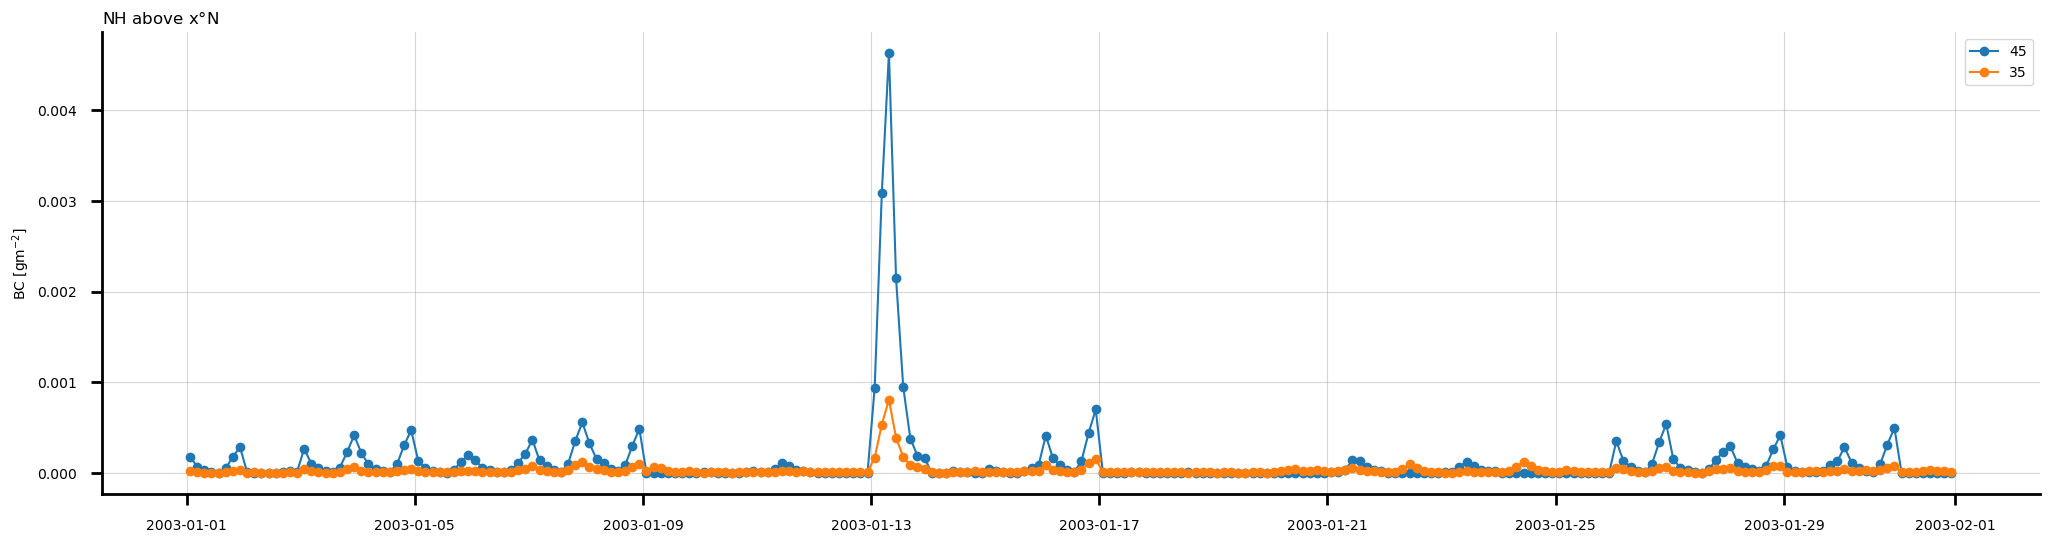

In [24]:
ds_45 = ds_year.where(ds_year['lat'] > 45)
lat_lon_mean_45 = ds_45.mean(dim='lat').mean(dim='lon')
datetimes_45 = lat_lon_mean_45.datetime.values
BC_45 = lat_lon_mean_45[emission_type].values


ds_35 = ds_year.where(ds_year['lat'] > 35)
lat_lon_mean_35 = ds_35.mean(dim='lat').mean(dim='lon')
datetimes_35 = lat_lon_mean_35.datetime.values
BC_35 = lat_lon_mean_35[emission_type].values

fig, ax = plt.subplots(figsize=(25,6))

ax.plot(datetimes_45, BC_45, 'o-', mfc=None, label='45')
ax.plot(datetimes_35, BC_35, 'o-', mfc=None, label='35')

ax.set_ylabel(str(emission_type)+" [gm$^{-2}$]")
fancy(ax, fontsize=10)
ax.set_title('NH above x$\degree$N', loc='left')
ax.legend()

plt.show()

In [38]:
def above_x_lat(ds_year, threshold_lat):
    ds_NH = ds_year.where(ds_year['lat'] > 0)
    ds_lat = ds_NH.where(ds_NH['lat'] > threshold_lat)
    lat_lon_mean = ds_lat.mean(dim='lat').mean(dim='lon')
    datetimes = lat_lon_mean.datetime.values
    BC = lat_lon_mean[emission_type].values
    return BC, datetimes

In [39]:
def lat_min_max(ds_year, threshold_max, threshold_min):
    ds_min = ds_year.where(ds_year['lat'] > threshold_min)
    ds_max = ds_min.where(ds_min['lat'] < threshold_max)
    lat_lon_mean = ds_max.mean(dim='lat').mean(dim='lon')
    datetimes = lat_lon_mean.datetime.values
    BC = lat_lon_mean[emission_type].values
    return BC, datetimes

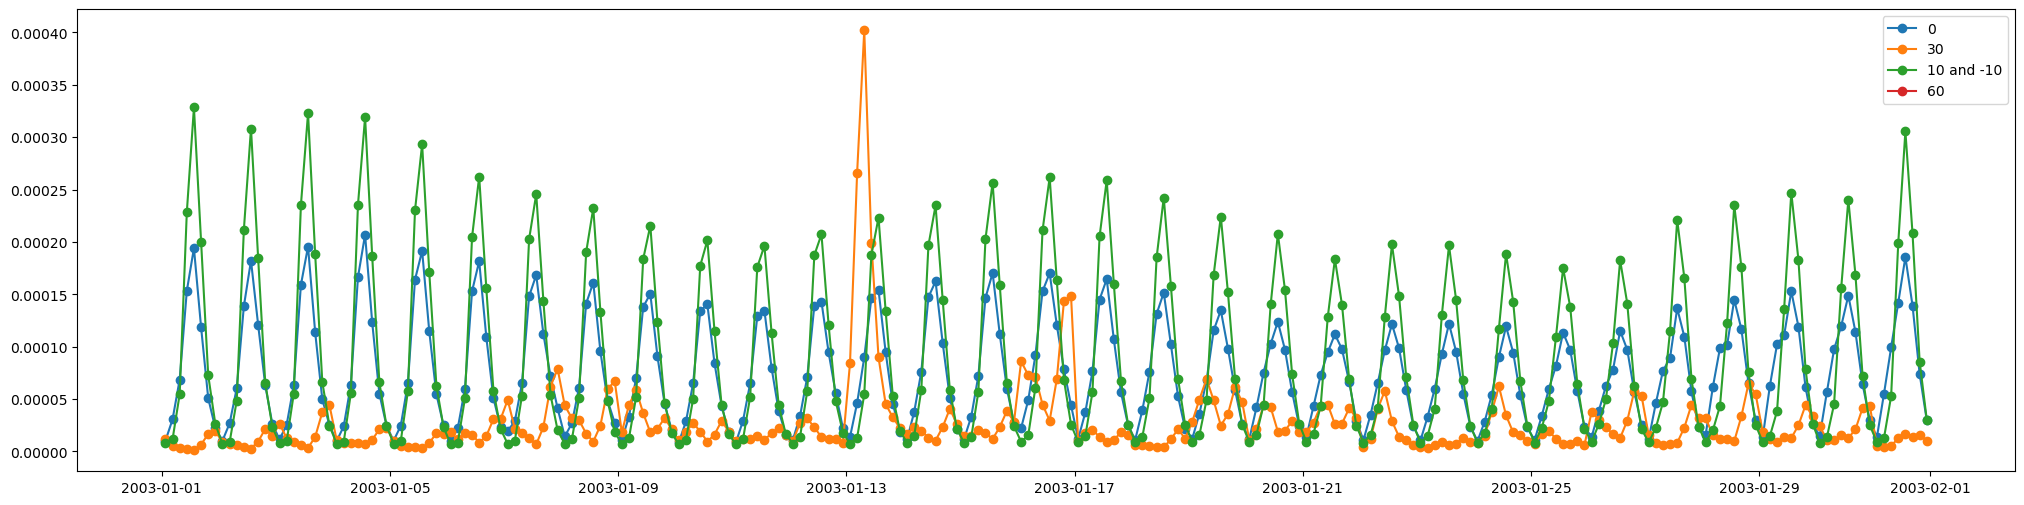

In [41]:
fig, ax = plt.subplots(figsize=(25,6))

lat = 0
BC, datetimes = above_x_lat(ds_year, threshold_lat=lat)
ax.plot(datetimes, BC, 'o-', mfc=None, label=str(lat))

lat = 30
BC, datetimes = above_x_lat(ds_year, threshold_lat=lat)
ax.plot(datetimes, BC, 'o-', mfc=None, label=str(lat))

lat = 50
BC, datetimes = lat_min_max(ds_year, threshold_max=10, threshold_min=-10)
ax.plot(datetimes, BC, 'o-', mfc=None, label=str('10 and -10'))

lat = 60
BC, datetimes = above_x_lat(ds_year, threshold_lat=lat)
ax.plot(datetimes, BC, 'o-', mfc=None, label=str(lat))

ax.legend()

plt.show()